In [1]:
## Twint
import twint
import nest_asyncio
from getpass import getpass
from time import sleep
from selenium.webdriver.common.keys import Keys
# from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

nest_asyncio.apply()

In [2]:
ResourcePath = "Resource/"

In [3]:
def getTwint(username, keyword, since, until, filename, mode):
    f = open(ResourcePath + filename, mode)
    f.write('')
    f.close()

    c = twint.Config()
    c.Username = username
    c.Search = keyword
    c.Since = since
    c.Until = until
    c.Count = True         
    c.Retweets = True
    c.Stats = True 
    c.Show_hashtags = True
    c.Hide_output = True
    c.Store_json = True
    c.Output = ResourcePath + filename

    twint.run.Search(c)
    sleep(5)

In [ ]:
# getTwint('PRFMnews', 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before.json', 'w')
# getTwint('PRFMnews', 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2021-02-15", "2021-05-15", 'after.json', 'w')

In [4]:
## Selenium
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs",prefs)
# chrome_options.add_argument('headless') # untuk menutup browser

#specify the path to chromedriver.exe
driver = webdriver.Chrome('D:\Kuliah\chromedriver.exe',chrome_options=chrome_options)

<ipython-input-4-26e73de032b8>:8: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('D:\Kuliah\chromedriver.exe',chrome_options=chrome_options)


In [5]:
driver.get('https://www.twitter.com/login')
sleep(2)

username = driver.find_element_by_xpath('//input[@name="session[username_or_email]"]')
username.send_keys('082245247958')

my_password = getpass()

password = driver.find_element_by_xpath('//input[@name="session[password]"]')
password.send_keys(my_password)
password.send_keys(Keys.RETURN)

In [6]:
def get_list_likes(link):
    list_likes = set()
    driver.get(link + '/likes')#open link
    sleep(5) #jeda waktu
    
    #scroll to bottom
    SCROLL_PAUSE_TIME = 0.5
    driver.execute_script("a = document.getElementsByClassName('r-1pp923h');")
    last_height = driver.execute_script("return a[0].scrollHeight")
    while True:
        try:
            likes_container = driver.find_element_by_xpath('//div[@aria-label="Timeline: Liked by"]') #element dasar likes
            if likes_container: #jika ada maka
                likes = likes_container.find_elements_by_xpath('.//div[@dir="ltr"]/span')
                for like in likes:
                    list_likes.add(like.text[1:]) # Delete @
        except:
            pass
        driver.execute_script("a[0].scrollTop = " + str(last_height))
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return a[0].scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return list(list_likes)

In [7]:
def get_list_retweets(link):
    list_retweets = set()
    driver.get(link + '/retweets')#open link
    sleep(5) #jeda waktu
    
    #scroll to bottom
    SCROLL_PAUSE_TIME = 0.5
    driver.execute_script("a = document.getElementsByClassName('r-1pp923h');")
    last_height = driver.execute_script("return a[0].scrollHeight")
    while True:
        try:
            retweets_container = driver.find_element_by_xpath('//div[@aria-label="Timeline: Retweeted by"]')
            if retweets_container: #jika ada maka
                retweets = retweets_container.find_elements_by_xpath('.//div[@dir="ltr"]/span')
                for retweet in retweets:
                    list_retweets.add(retweet.text[1:]) # Delete @
        except:
            pass
        driver.execute_script("a[0].scrollTop = " + str(last_height))
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return a[0].scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return list(list_retweets)

In [8]:
# Iterasi semua tweet terkait untuk dicari likes dan retweets
def getInteraction(dfTweets, filename, user_done):
    tweet_ids = dfTweets['id'].values.tolist()
    tweet_usernames = dfTweets['username'].values.tolist()
    interactionList = []
    for i in range(len(tweet_ids)):
        if tweet_usernames[i] in user_done:
            continue

        while True:
            try:
                tweet_id = tweet_ids[i]
                tweet_username = tweet_usernames[i]
                uri = 'https://twitter.com/'+ tweet_username + '/status/'
                interaction = {
                    'tweet_id' : tweet_id,
                    'username' : tweet_username,
                    'likes' : get_list_likes(uri + str(tweet_id)),
                    'retweet' : get_list_retweets(uri + str(tweet_id))
                }
            except:
                sleep(5)
                continue
            break

        interactionList.append(interaction)
        interactionJSON = json.dumps(interactionList)
        with open(ResourcePath + filename, 'w+') as f:
            f.write(interactionJSON)


In [9]:
def getConvertToList(filename):
    with open(ResourcePath + filename, 'r') as f:
        interactionJSON = f.read()
        interactions = json.loads(interactionJSON)

    likes_dict = dict()
    retweets_dict = dict()
    for interaction in interactions:
        for account in interaction['likes']:
            likes_dict[account] = likes_dict.get(account,0) + 1
        for account in interaction['retweet']:
            retweets_dict[account] = retweets_dict.get(account, 0) + 1

    likes_dict = dict(sorted(likes_dict.items(), key=lambda item: item[1], reverse=True))
    retweets_dict = dict(sorted(retweets_dict.items(), key=lambda item: item[1], reverse=True))

    return likes_dict, retweets_dict


In [10]:
def getUserPotent(filename, user_done, minInteraction):
    likes_dict, retweets_dict = getConvertToList(filename)
    likes_potent = []
    retweets_potent = []
    for username, count in likes_dict.items():
        if username.lower() in user_done:
            continue
        if count >= minInteraction:
            likes_potent.append(username.lower())

    for username, count in retweets_dict.items():
        if username.lower() in user_done:
            continue
        if count >= minInteraction:
            retweets_potent.append(username.lower())

    user_potent = likes_potent + list(set(retweets_potent) - set(likes_potent))
    return user_potent

In [21]:
user_done_bf = set()
user_done_af = set()

In [22]:
dfBefore = pd.read_json( ResourcePath + 'before.json' , lines = True)
dfAfter = pd.read_json( ResourcePath + 'after.json' , lines = True)
dfAll = dfBefore.append(dfAfter)

# getInteraction(dfBefore, 'beforeInteraction.json', user_done_bf)
# getInteraction(dfAfter, 'afterInteraction.json', user_done_af)

user_done_bf.update(set(dfBefore['username'].values.tolist()))
user_done_af.update(set(dfAfter['username'].values.tolist()))

In [23]:
bf_Potent = getUserPotent('beforeInteraction.json', user_done_af, 2)
# for i in bf_Potent:
#     try:
#         getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_d1.json', 'a')
#     except:
#         continue

af_Potent = getUserPotent('afterInteraction.json', user_done_af, 2)
# for i in af_Potent:
#     try:
#         getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2021-02-15", "2021-05-15", 'after_d1.json', 'a')
#     except:
#         continue

In [24]:
dfBefore = pd.read_json( ResourcePath + 'before_d1.json' , lines = True)
dfAfter = pd.read_json( ResourcePath + 'after_d1.json' , lines = True)
dfAll = dfBefore.append(dfAfter)

# getInteraction(dfBefore, 'beforeInteraction_d1.json', user_done_bf)
# getInteraction(dfAfter, 'afterInteraction_d1.json', user_done_af)

user_done_bf.update(set(dfBefore['username'].values.tolist()))
user_done_af.update(set(dfAfter['username'].values.tolist()))

In [25]:
bf_Potent = getUserPotent('beforeInteraction_d1.json', user_done_bf, 2)
# for i in bf_Potent:
    # try:
    #     getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_d2.json', 'a')
    # except:
    #     continue

af_Potent = getUserPotent('afterInteraction_d1.json', user_done_af, 2)
# for i in af_Potent:
#     try:
#         getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2021-02-15", "2021-05-15", 'after_d2.json', 'a')
#     except:
#         continue

In [26]:
# Get JSON max item computed
dfBefore = pd.read_json( ResourcePath + 'before_d2.json' , lines = True)
dfAfter = pd.read_json( ResourcePath + 'after_d2.json' , lines = True)
dfAll = dfBefore.append(dfAfter)

# getInteraction(dfBefore, 'beforeInteraction_d2.json', user_done_bf)
# getInteraction(dfAfter, 'afterInteraction_d2.json', user_done_af)

user_done_bf.update(set(dfBefore['username'].values.tolist()))
user_done_af.update(set(dfAfter['username'].values.tolist()))

In [ ]:
################## dr_koko snowball #####################

# def getInteractionToUser(filename, save_filename, user):
#     with open(ResourcePath + filename, 'r') as f:
#         interactionJSON = f.read()
#         interactions = json.loads(interactionJSON)

#     savelist = []
#     for i in interactions:
#         if i['username'] == user:
#             savelist.append(i)
#     with open(ResourcePath + save_filename, 'w+') as f:
#         f.write(json.dumps(savelist))
#     return

In [ ]:
# getInteractionToUser('beforeInteraction_d2.json', 'beforeInteraction_koko.json' ,'dr_koko28')

In [11]:
user_done_koko = set()

In [ ]:
# getTwint('dr_koko28', 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_koko.json', 'w')

In [12]:
dfKoko = pd.read_json( ResourcePath + 'before_koko.json' , lines = True)
# getInteraction(dfKoko, 'beforeInteraction_koko.json', user_done_koko)
user_done_koko.update(set(dfKoko['username'].values.tolist()))

In [20]:
koko_Potent = getUserPotent('beforeInteraction_koko.json', user_done_koko, 15)
# print(len(koko_Potent))
# for i in koko_Potent:
#     try:
#         getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_koko_d1.json', 'a')
#     except:
#         continue

48
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets from @bekeraza.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 1 Tweets from @aryans_karo.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets from @enirositaa.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets from @asihsun44472129.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets from @ex23038856.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets from @gesti_90.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 2 Tweet

In [44]:
dfKoko = pd.read_json( ResourcePath + 'before_koko_d1.json' , lines = True)
# getInteraction(dfKoko, 'beforeInteraction_koko_d1.json', user_done_koko)
user_done_koko.update(set(dfKoko['username'].values.tolist()))

In [190]:
koko_Potent = getUserPotent('beforeInteraction_koko_d1.json', user_done_koko, 2)
# print(len(koko_Potent))
# for i in koko_Potent:
#     try:
#         getTwint(i, 'vaksin OR vaksinasi OR astrazeneca OR sinovac', "2020-08-01", "2021-01-31", 'before_koko_d2.json', 'a')
#     except:
#         continue

10


In [191]:
dfKoko = pd.read_json( ResourcePath + 'before_koko_d2.json' , lines = True)
# getInteraction(dfKoko, 'beforeInteraction_koko_d2.json', user_done_koko)
user_done_koko.update(set(dfKoko['username'].values.tolist()))

In [ ]:
##################### END #########################



In [27]:
def getEdges(filename):
    with open(ResourcePath + filename, 'r') as f:
        interactionJSON = f.read()
        interactions = json.loads(interactionJSON)

    likes_dict = dict()
    retweets_dict = dict()

    for interaction in interactions:
        firstAccount = interaction['username']
        for secondAccount in interaction['likes']:
            tupleAccount = (firstAccount, secondAccount.lower())
            likes_dict[tupleAccount] = likes_dict.get(tupleAccount,0) + 1
        for secondAccount in interaction['retweet']:
            tupleAccount = (firstAccount, secondAccount.lower())
            retweets_dict[tupleAccount] = retweets_dict.get(tupleAccount,0) + 1

    return likes_dict, retweets_dict

In [193]:
bf_edgesRoot_likes, bf_edgesRoot_retweet = getEdges('beforeInteraction.json')
bf_edgesD1_likes, bf_edgesD1_retweet = getEdges('beforeInteraction_d1.json')
bf_edgesD2_likes, bf_edgesD2_retweet = getEdges('beforeInteraction_d2.json')

af_edgesRoot_likes, af_edgesRoot_retweet = getEdges('afterInteraction.json')
af_edgesD1_likes, af_edgesD1_retweet = getEdges('afterInteraction_d1.json')
af_edgesD2_likes, af_edgesD2_retweet = getEdges('afterInteraction_d2.json')

koko_edgesRoot_likes, koko_edgesRoot_retweet = getEdges('beforeInteraction_koko.json')
koko_edgesD1_likes, koko_edgesD1_retweet = getEdges('beforeInteraction_koko_d1.json')
koko_edgesD2_likes, koko_edgesD2_retweet = getEdges('beforeInteraction_koko_d2.json')

In [52]:
import itertools 
import collections

def combineDict(dict1, dict2):
    Cdict = collections.defaultdict(int)
    
    for key, val in itertools.chain(dict1.items(), dict2.items()):
        Cdict[key] += val
    return dict(Cdict)

In [372]:
def getNodesEdges(edgelist):
    node = set()
    for userTuple, i in edgelist.items():
        node.add(userTuple[0])
        node.add(userTuple[1])
    return len(node), len(edgelist)

getNodesEdges(combineDict(koko_edgesRoot_likes, koko_edgesRoot_retweet))

(5853, 5852)

In [352]:
bf_edgesRoot = combineDict(bf_edgesRoot_likes, bf_edgesRoot_retweet)
bf_edgesD1 = combineDict(bf_edgesD1_likes, bf_edgesD1_retweet)
bf_edgesD2 = combineDict(bf_edgesD2_likes, bf_edgesD2_retweet)
koko_edgesD1 = combineDict(koko_edgesD1_likes, koko_edgesD1_retweet)
koko_edgesD2 = combineDict(koko_edgesD2_likes, koko_edgesD2_retweet)

bf_edges = combineDict(bf_edgesRoot, bf_edgesD1)
bf_edges = combineDict(bf_edges, bf_edgesD2)
bf_edges = combineDict(bf_edges, koko_edgesD1)
# bf_edges = combineDict(bf_edges, koko_edgesD2)

af_edgesRoot = combineDict(af_edgesRoot_likes, af_edgesRoot_retweet)
af_edgesD1 = combineDict(af_edgesD1_likes, af_edgesD1_retweet)
af_edgesD2 = combineDict(af_edgesD2_likes, af_edgesD2_retweet)
af_edges = combineDict(af_edgesRoot, af_edgesD1)
af_edges = combineDict(af_edges, af_edgesD2)


In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import mpld3
import re
import itertools
import math

In [353]:
bf_nodes = dict()
af_nodes = dict()

for userTuple, weight in bf_edges.items():
    a, b = userTuple
    bf_nodes[a] = bf_nodes.get(a, 1) + weight
    bf_nodes[b] = bf_nodes.get(b, 1)

for userTuple, weight in af_edges.items():
    a, b = userTuple
    af_nodes[a] = af_nodes.get(a, 1) + weight
    af_nodes[b] = af_nodes.get(b, 1)

In [239]:
def AddLabel(sortedlist, dictlabel):
    for curr_account, val in sortedlist:
        if val > 0:
            dictlabel[curr_account] = curr_account

def forceatlas2_layout(G, iterations=30, linlog=False, pos=None, nohubs=False,
                       kr=0.001, k=None, dim=2):
    """
    Options values are
    g                The graph to layout
    iterations       Number of iterations to do
    linlog           Whether to use linear or log repulsion
    random_init      Start with a random position
                     If false, start with FR
    avoidoverlap     Whether to avoid overlap of points
    degreebased      Degree based repulsion
    """
    # We add attributes to store the current and previous convergence speed
    for n in G:
        G.nodes[n]['prevcs'] = 0
        G.nodes[n]['currcs'] = 0
        # To numpy matrix
    # This comes from the spares FR layout in nx
    A = nx.to_scipy_sparse_matrix(G, dtype='f')
    nnodes, _ = A.shape

    try:
        A = A.tolil()
    except Exception as e:
        A = (coo_matrix(A)).tolil()
    if pos is None:
        pos = np.asarray(np.random.random((nnodes, dim)), dtype=A.dtype)
    else:
        pos = pos.astype(A.dtype)
    if k is None:
        k = np.sqrt(1.0 / nnodes)
        # Iterations
    # the initial "temperature" is about .1 of domain area (=1x1)
    # this is the largest step allowed in the dynamics.
    t = 0.1
    # simple cooling scheme.
    # linearly step down by dt on each iteration so last iteration is size dt.
    dt = t / float(iterations + 1)
    displacement = np.zeros((dim, nnodes))
    for iteration in range(iterations):
        displacement *= 0
        # loop over rows
        for i in range(A.shape[0]):
            # difference between this row's node position and all others
            delta = (pos[i] - pos).T
            # distance between points
            distance = np.sqrt((delta ** 2).sum(axis=0))
            # enforce minimum distance of 0.01
            distance = np.where(distance < 0.01, 0.01, distance)
            # the adjacency matrix row
            Ai = np.asarray(A.getrowview(i).toarray())
            # displacement "force"
            Dist = k * k / distance ** 2
            if nohubs:
                Dist = Dist / float(Ai.sum(axis=1) + 1)
            if linlog:
                Dist = np.log(Dist + 1)
            displacement[:, i] += \
                (delta * (Dist - Ai * distance / k)).sum(axis=1)
            # update positions
        length = np.sqrt((displacement ** 2).sum(axis=0))
        length = np.where(length < 0.01, 0.01, length)
        pos += (displacement * t / length).T
        # cool temperature
        t -= dt
        # Return the layout
    return dict(zip(G, pos))


In [ ]:
##################### Graph G1 #############################

In [354]:
G1 = nx.DiGraph()

node = []
nodeSize = []
nodeColor = []

for key, value in bf_nodes.items():
    G1.add_node(key)
    node.append(key)

minSize = 5
for key, value in bf_edges.items():
    if(value >= minSize ):
        G1.add_edge(key[1], key[0], weight = 1 / value)

G1.remove_nodes_from(list(nx.isolates(G1)))
for key, value in bf_nodes.items():
    if key in list(G1.nodes):
        nodeSize.append(math.sqrt(value * 100) * 10)
        # nodeSize.append(math.sqrt(value * 100) * 10)
        nodeColor.append(math.log(value))

print(len(G1.nodes))
print(G1.number_of_edges())

484
485


In [355]:
labels = {}
table = pd.DataFrame()


In [356]:
sorted_x = sorted(dict(nx.degree(G1)).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:10], labels)
sorted_x[0:10]

table = pd.DataFrame(sorted_x, columns=['username','degree'])
table

username  degree
0        dr_koko28     455
1         prfmnews      23
2    alinggabuana_       5
3          biano64       3
4    jumhanatintin       2
..             ...     ...
479   agus10618284       1
480      kelana_m5       1
481         165nlm       1
482  23_syaifulloh       1
483    yassirlyhsn       1

[484 rows x 2 columns]

In [359]:
sorted_x = sorted(nx.eigenvector_centrality(G1, 200).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:10], labels)
sorted_x[0:10]

# table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','eigenvector_centrality']), on='username')
# table

[('alinggabuana_', 0.9999999512295316),
 ('dr_koko28', 0.0003119111187845794),
 ('prfmnews', 1.5795231507341404e-05),
 ('evalez_fr', 1.4007092091416004e-06),
 ('clickbandung', 7.15255766370179e-07),
 ('widaoktavia1', 2.980232359875746e-08),
 ('rendikalanipra2', 2.980232359875746e-08),
 ('mamiy62', 2.980232359875746e-08),
 ('rkmiddleeast', 2.980232359875746e-08),
 ('drasidin', 2.980232359875746e-08)]

In [358]:
sorted_x = sorted(nx.closeness_centrality(G1).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:10], labels)
sorted_x[0:10]

# table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','closeness_centrality']), on='username')
# table

[('dr_koko28', 0.9420289855072463),
 ('prfmnews', 0.047619047619047616),
 ('alinggabuana_', 0.006211180124223602),
 ('evalez_fr', 0.004140786749482402),
 ('clickbandung', 0.002070393374741201),
 ('widaoktavia1', 0.0),
 ('rendikalanipra2', 0.0),
 ('mamiy62', 0.0),
 ('rkmiddleeast', 0.0),
 ('drasidin', 0.0)]

In [345]:
sorted_x = sorted(nx.betweenness_centrality(G1).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:10], labels)
sorted_x[0:10]

table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','betweeness_centrality']), on='username')
table

username  degree  eigenvector_centrality  closeness_centrality  \
0          dr_koko28     455            3.269911e-04              0.777793   
1      radioelshinta     102            6.994605e-05              0.174359   
2           prfmnews      23            1.579523e-05              0.039316   
3      alinggabuana_       5            9.999999e-01              0.005128   
4            biano64       3            2.980232e-08              0.000000   
..               ...     ...                     ...                   ...   
581  beritasukoharjo       1            2.980232e-08              0.000000   
582   elshintategal_       1            2.980232e-08              0.000000   
583     muslich_leva       1            2.980232e-08              0.000000   
584   elshintadotcom       1            2.980232e-08              0.000000   
585          ashaamw       1            2.980232e-08              0.000000   

     betweeness_centrality  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
..                     ...  
581                    0.0  
582                    0.0  
583                    0.0  
584                    0.0  
585                    0.0  

[586 rows x 5 columns]

In [370]:
table = table.sort_values(by=['closeness_centrality', 'eigenvector_centrality'], ascending=False)[:10]
table.style.hide_index()[:10]

KeyError: 'closeness_centrality'

In [368]:
sorted_x = sorted(nx.pagerank(G1).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[0:10], labels)
sorted_x[0:10]

table = pd.DataFrame(sorted_x, columns=['username','pagerank'])
# table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','pagerank']), on='username')
# table.style.hide_index()

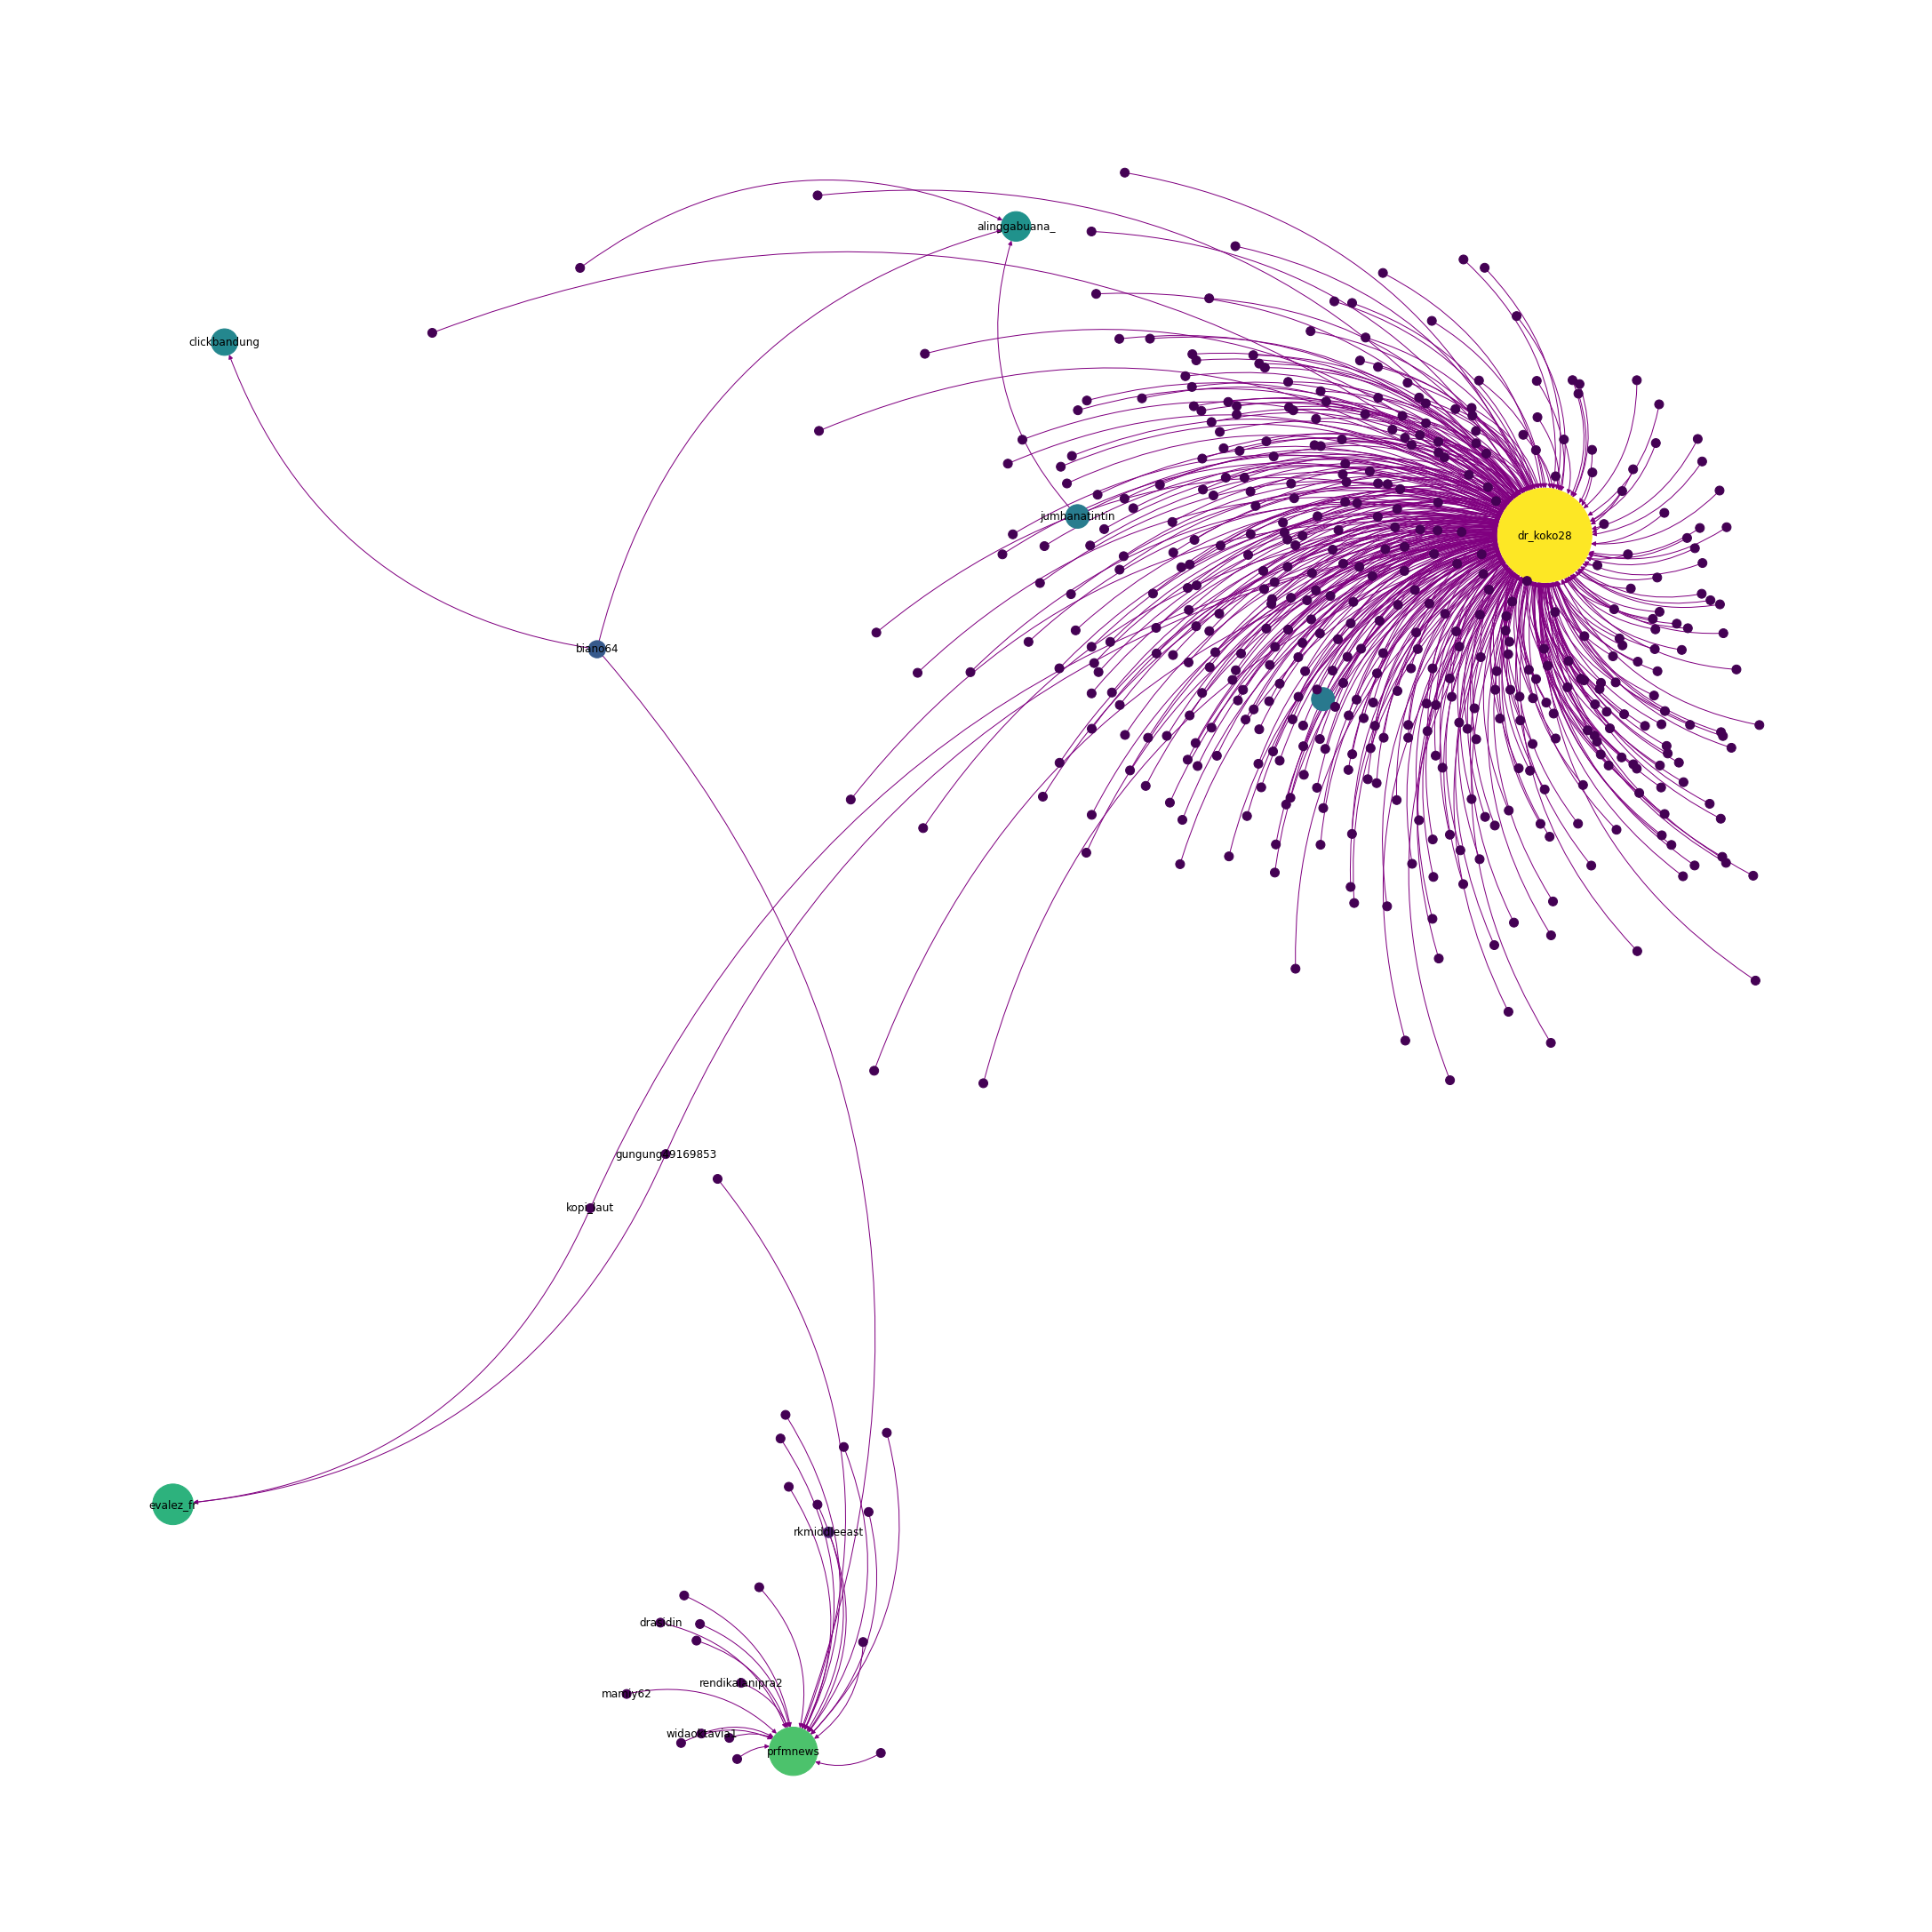

In [234]:
plt.figure(figsize=(30,30))
# pos = nx.spring_layout(G1)
# pos = forceatlas2_layout(G1)
nx.draw(G1, with_labels=False, edge_color='purple', node_size=nodeSize, node_color=nodeColor ,node_shape = 'o' , pos=pos, connectionstyle='arc3, rad = -0.3')
nx.draw_networkx_labels(G1, pos ,labels=labels)
plt.show()

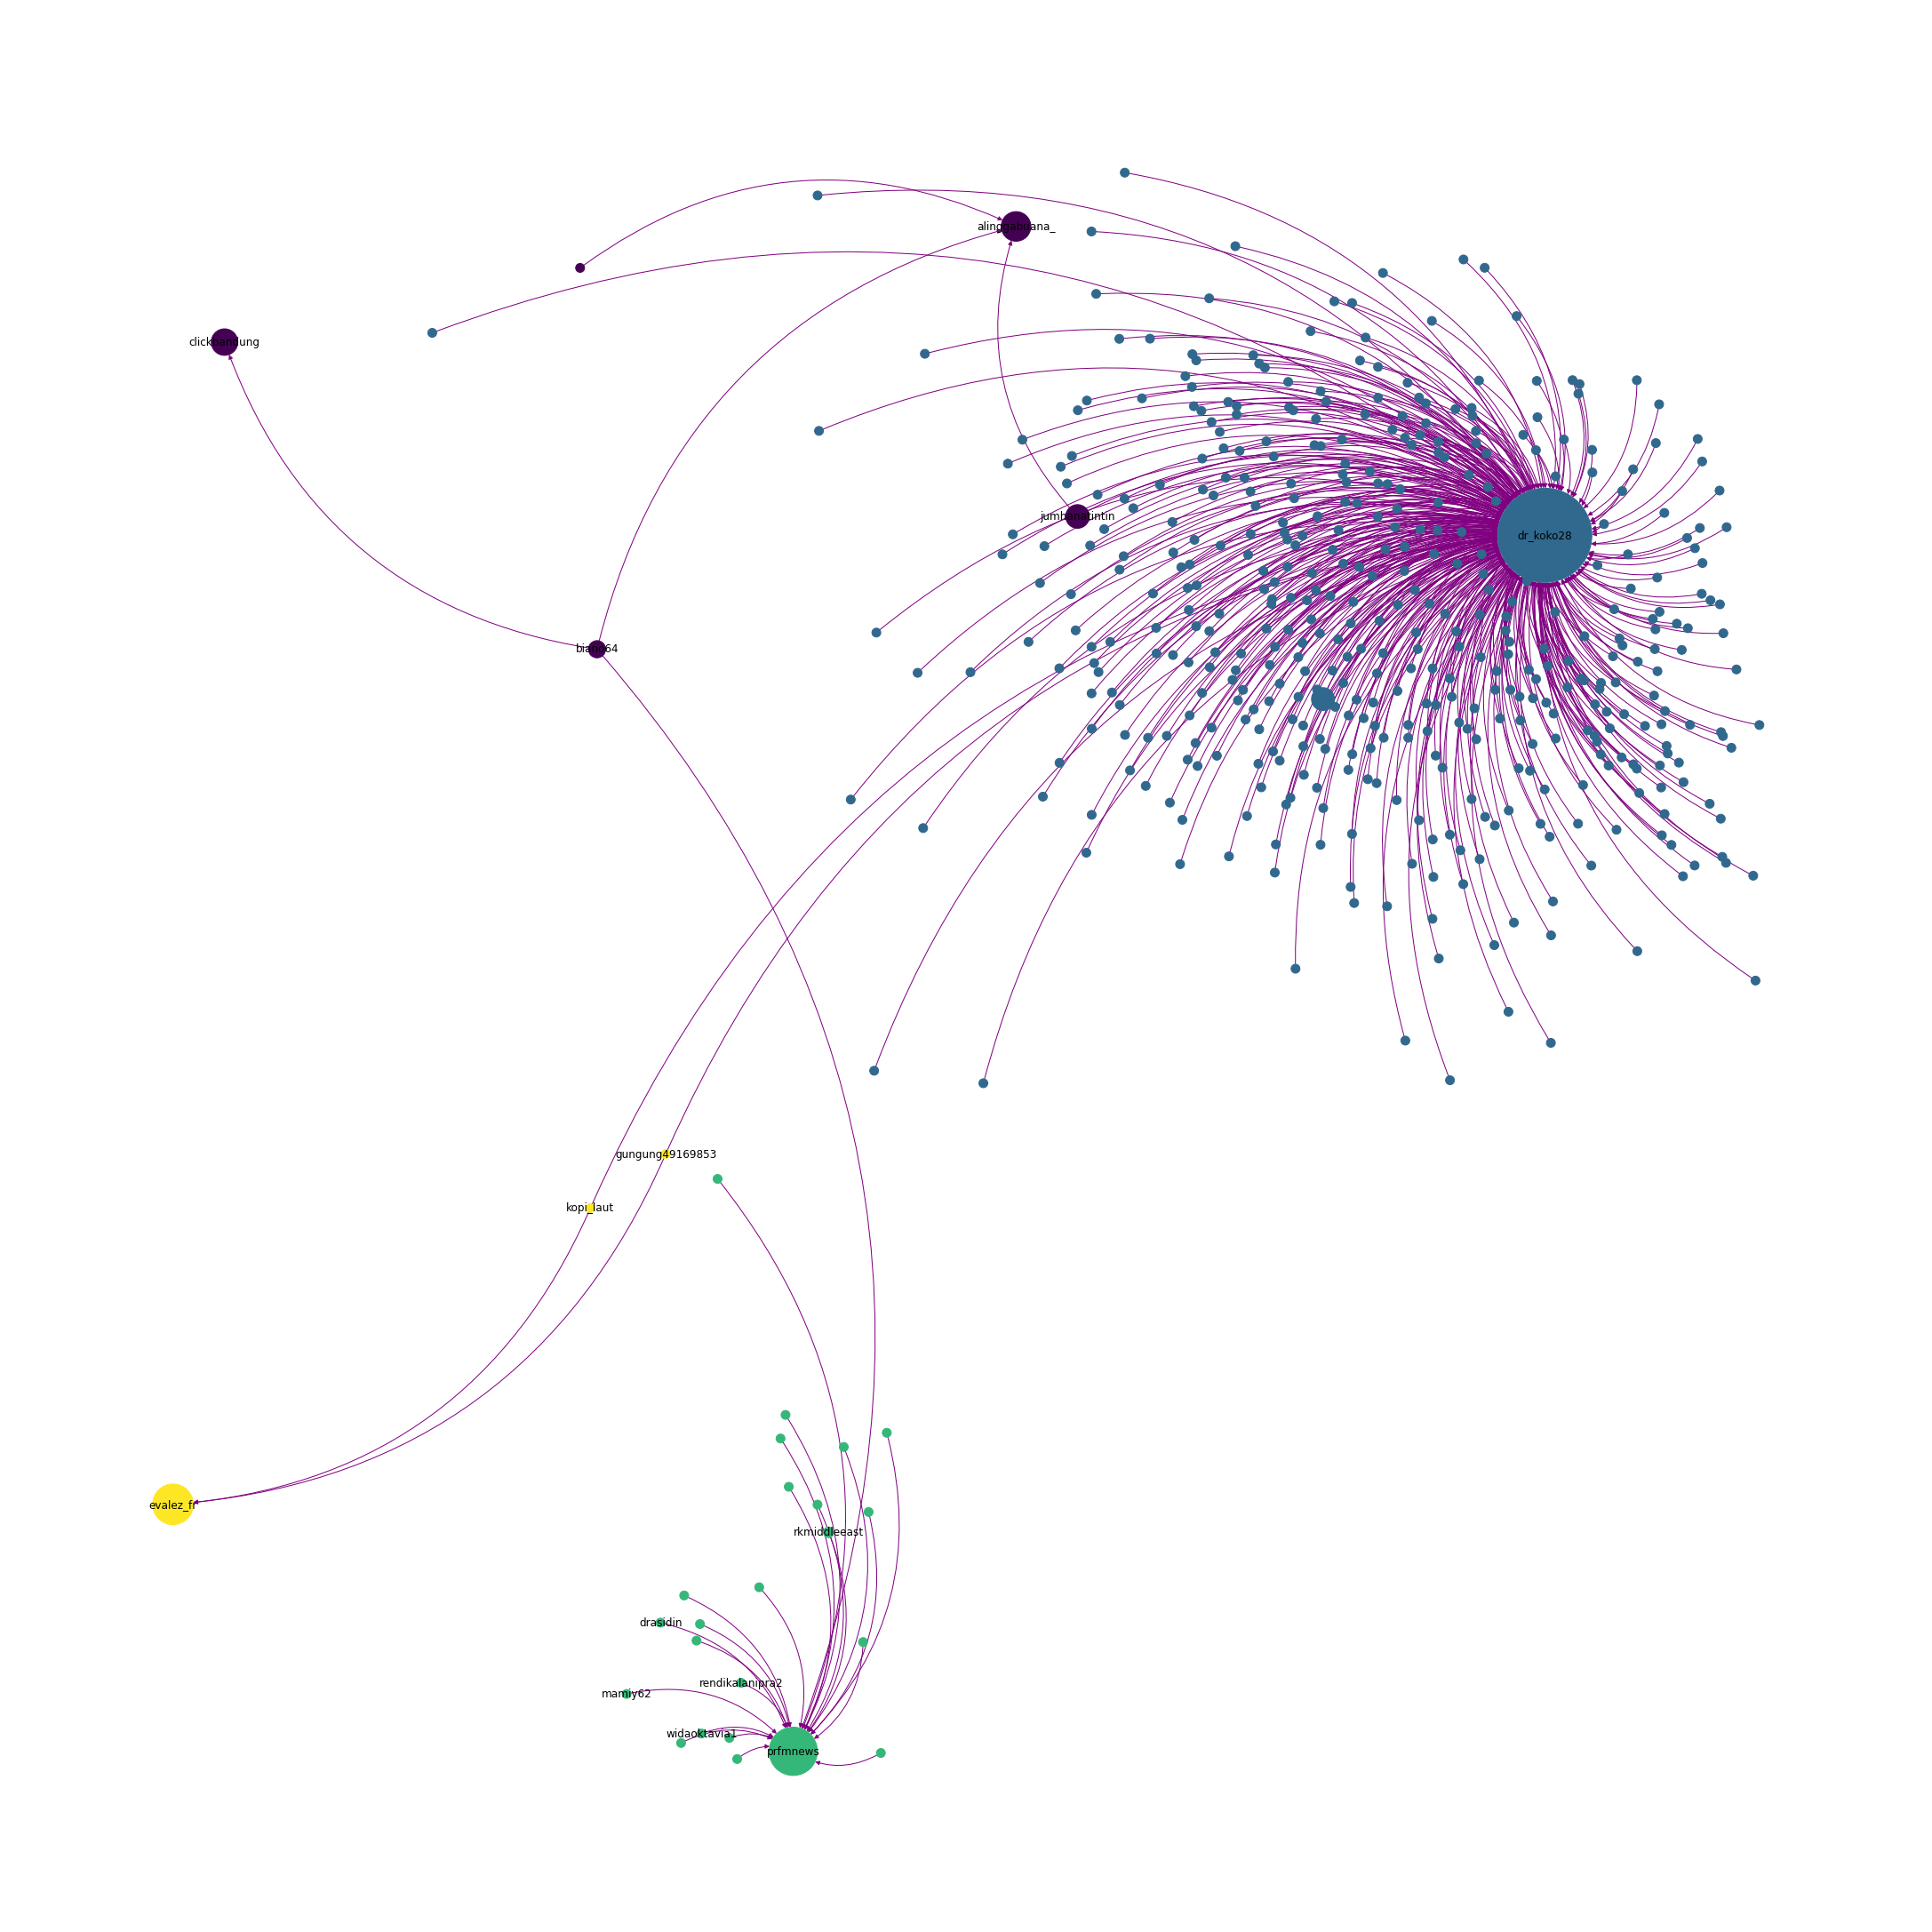

In [366]:
from networkx.algorithms import node_classification
G1_undirected = G1.to_undirected()

# 4 Actor Utama
# mainActor = ['alinggabuana_', 'dr_koko28', 'prfmnews', 'evalez_fr', 'radioelshinta']
mainActor = ['alinggabuana_', 'dr_koko28', 'prfmnews', 'evalez_fr']
mainActorDict = dict()
for idx, i in enumerate(mainActor):
    G1_undirected.nodes[i]['label'] = idx / 10
nodeColor = node_classification.harmonic_function(G1_undirected)

plt.figure(figsize=(30,30))
nx.draw(G1, with_labels=False, edge_color='purple', node_size=nodeSize, node_color=nodeColor ,node_shape = 'o' , pos=pos, connectionstyle='arc3, rad = -0.3')
nx.draw_networkx_labels(G1, pos ,labels=labels)
plt.show()

In [367]:
from collections import Counter
Counter(nodeColor)

Counter({0.2: 23, 0.0: 5, 0.1: 453, 0.3: 3})

In [ ]:
######################### Graph G2 #######################

In [330]:
G2 = nx.DiGraph()

node = []
nodeSize = []
nodeColor = []

for key, value in af_nodes.items():
    G2.add_node(key)
    node.append(key)

minSize = 2
for key, value in af_edges.items():
    if(value >= minSize ):
        G2.add_edge(key[1], key[0], weight = 1 / value)

G2.remove_nodes_from(list(nx.isolates(G2)))
for key, value in af_nodes.items():
    if key in list(G2.nodes):
        nodeSize.append(math.sqrt(value * 100) * 10)
        nodeColor.append(math.log(value))

print(len(G2.nodes))
print(G2.number_of_edges())

68
76


In [100]:
af_labels = {}

In [316]:
sorted_x = sorted(dict(nx.degree(G2)).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:10], af_labels)
sorted_x[0:10]

table = pd.DataFrame(sorted_x, columns=['username','degree'])
table

username  degree
0    bandung_dinkes      36
1           infobdg      19
2          prfmnews      14
3      halo_bandung       6
4   fitradiobandung       5
..              ...     ...
63     joker_cute01       1
64     akmalmursid1       1
65         akoemala       1
66        fbalgasir       1
67  purnamadewisari       1

[68 rows x 2 columns]

In [317]:
sorted_x = sorted(nx.eigenvector_centrality(G2, 200).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:10], af_labels)
sorted_x[0:10]

table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','eigenvector_centrality']), on='username')
table

username  degree  eigenvector_centrality
0    bandung_dinkes      36            7.071091e-01
1           infobdg      19            4.082516e-01
2          prfmnews      14            4.082527e-01
3      halo_bandung       6            4.082365e-01
4   fitradiobandung       5            4.724763e-06
..              ...     ...                     ...
63     joker_cute01       1            8.914646e-08
64     akmalmursid1       1            8.914646e-08
65         akoemala       1            8.914646e-08
66        fbalgasir       1            8.914646e-08
67  purnamadewisari       1            8.914646e-08

[68 rows x 3 columns]

In [318]:
sorted_x = sorted(nx.closeness_centrality(G2).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:10], af_labels)
sorted_x[0:10]

table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','closeness_centrality']), on='username')
table

username  degree  eigenvector_centrality  closeness_centrality
0    bandung_dinkes      36            7.071091e-01              0.663366
1           infobdg      19            4.082516e-01              0.496296
2          prfmnews      14            4.082527e-01              0.465278
3      halo_bandung       6            4.082365e-01              0.416149
4   fitradiobandung       5            4.724763e-06              0.059701
..              ...     ...                     ...                   ...
63     joker_cute01       1            8.914646e-08              0.000000
64     akmalmursid1       1            8.914646e-08              0.000000
65         akoemala       1            8.914646e-08              0.000000
66        fbalgasir       1            8.914646e-08              0.000000
67  purnamadewisari       1            8.914646e-08              0.000000

[68 rows x 4 columns]

In [319]:
sorted_x = sorted(nx.betweenness_centrality(G2).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:10], af_labels)
sorted_x[0:10]

table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','betweenness_centrality']), on='username')
table

username  degree  eigenvector_centrality  closeness_centrality  \
0    bandung_dinkes      36            7.071091e-01              0.663366   
1           infobdg      19            4.082516e-01              0.496296   
2          prfmnews      14            4.082527e-01              0.465278   
3      halo_bandung       6            4.082365e-01              0.416149   
4   fitradiobandung       5            4.724763e-06              0.059701   
..              ...     ...                     ...                   ...   
63     joker_cute01       1            8.914646e-08              0.000000   
64     akmalmursid1       1            8.914646e-08              0.000000   
65         akoemala       1            8.914646e-08              0.000000   
66        fbalgasir       1            8.914646e-08              0.000000   
67  purnamadewisari       1            8.914646e-08              0.000000   

    betweenness_centrality  
0                 0.037087  
1                 0.010176  
2                 0.006784  
3                 0.001357  
4                 0.003618  
..                     ...  
63                0.000000  
64                0.000000  
65                0.000000  
66                0.000000  
67                0.000000  

[68 rows x 5 columns]

In [ ]:
table = table.sort_values(by=['closeness_centrality', 'eigenvector_centrality'], ascending=False)[:10]
table.style.hide_index()

In [324]:
sorted_x = sorted(nx.pagerank(G2).items(), key=lambda kv: kv[1], reverse=True)
AddLabel(sorted_x[:10], af_labels)
sorted_x[0:10]

table = pd.DataFrame(sorted_x, columns=['username','pagerank'])
# table = pd.merge(table, pd.DataFrame(sorted_x, columns=['username','pagerank']), on='username')
table.style.hide_index()

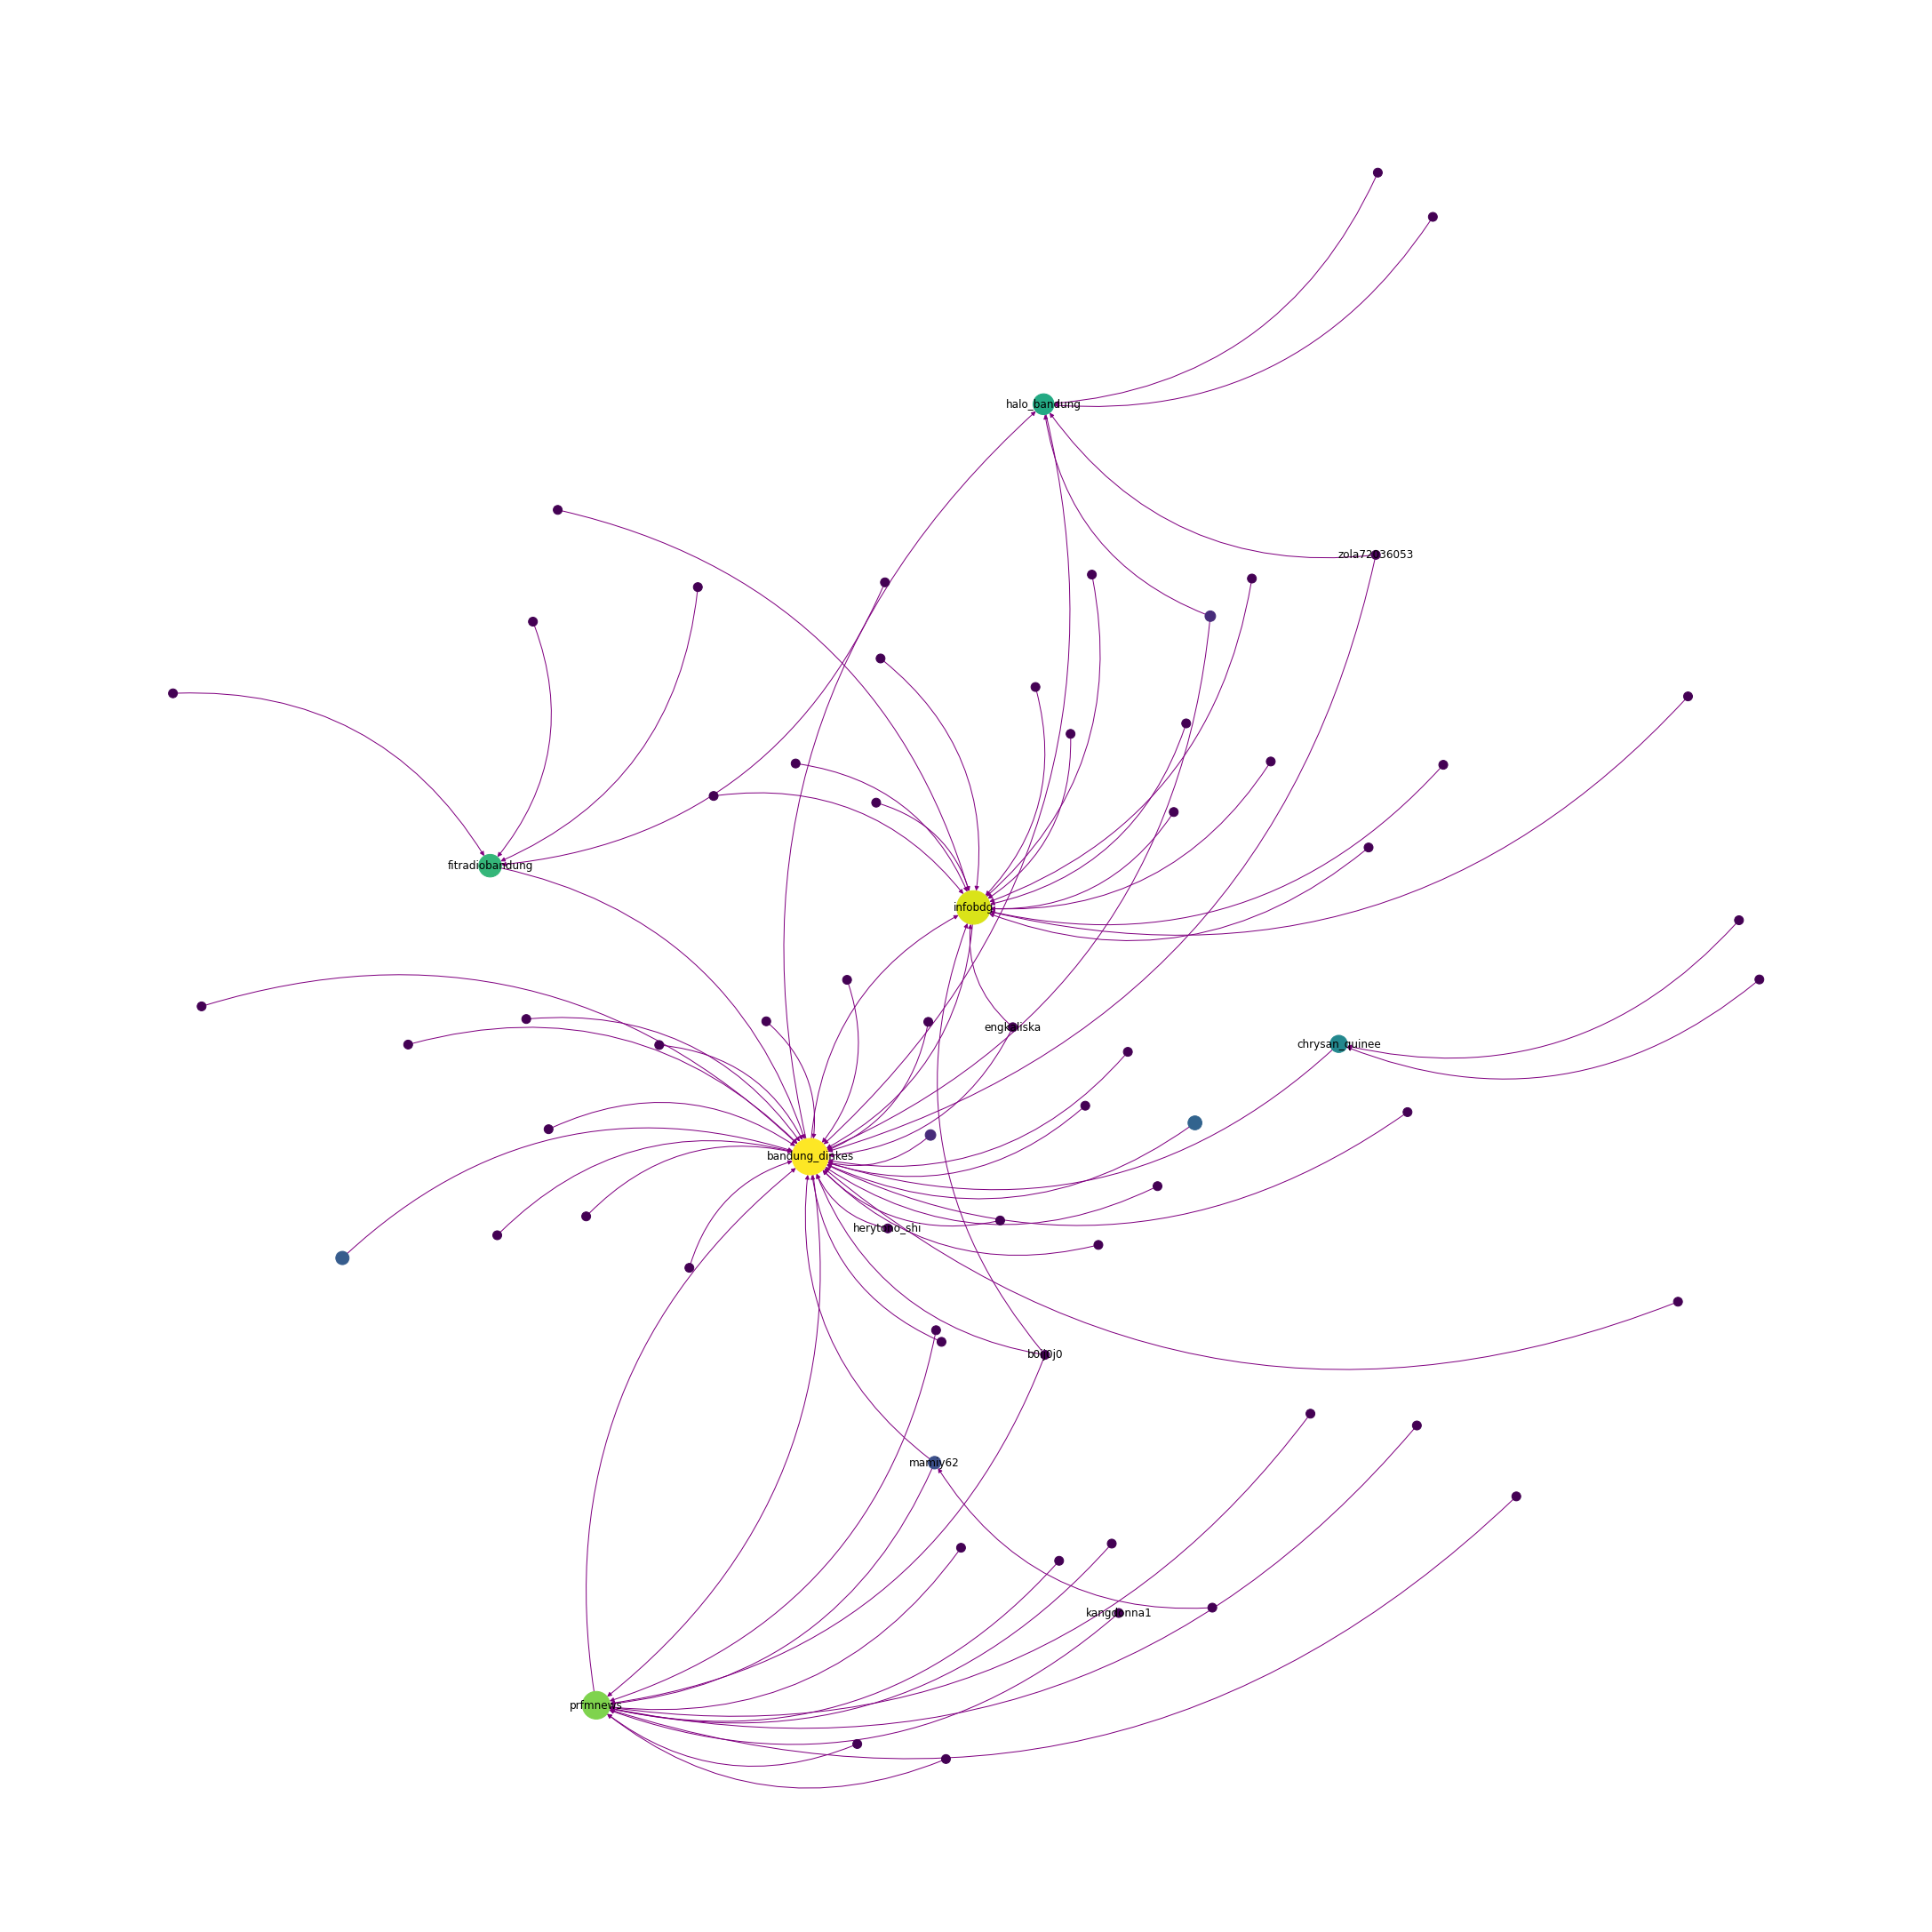

In [108]:
plt.figure(figsize=(30,30))
pos = nx.spring_layout(G2)
# pos = forceatlas2_layout(G2)
nx.draw(G2, with_labels=False, edge_color='purple', node_size=nodeSize, node_color=nodeColor ,node_shape = 'o' , pos=pos, connectionstyle='arc3, rad = -0.3')
nx.draw_networkx_labels(G2, pos ,labels=af_labels)
plt.show()

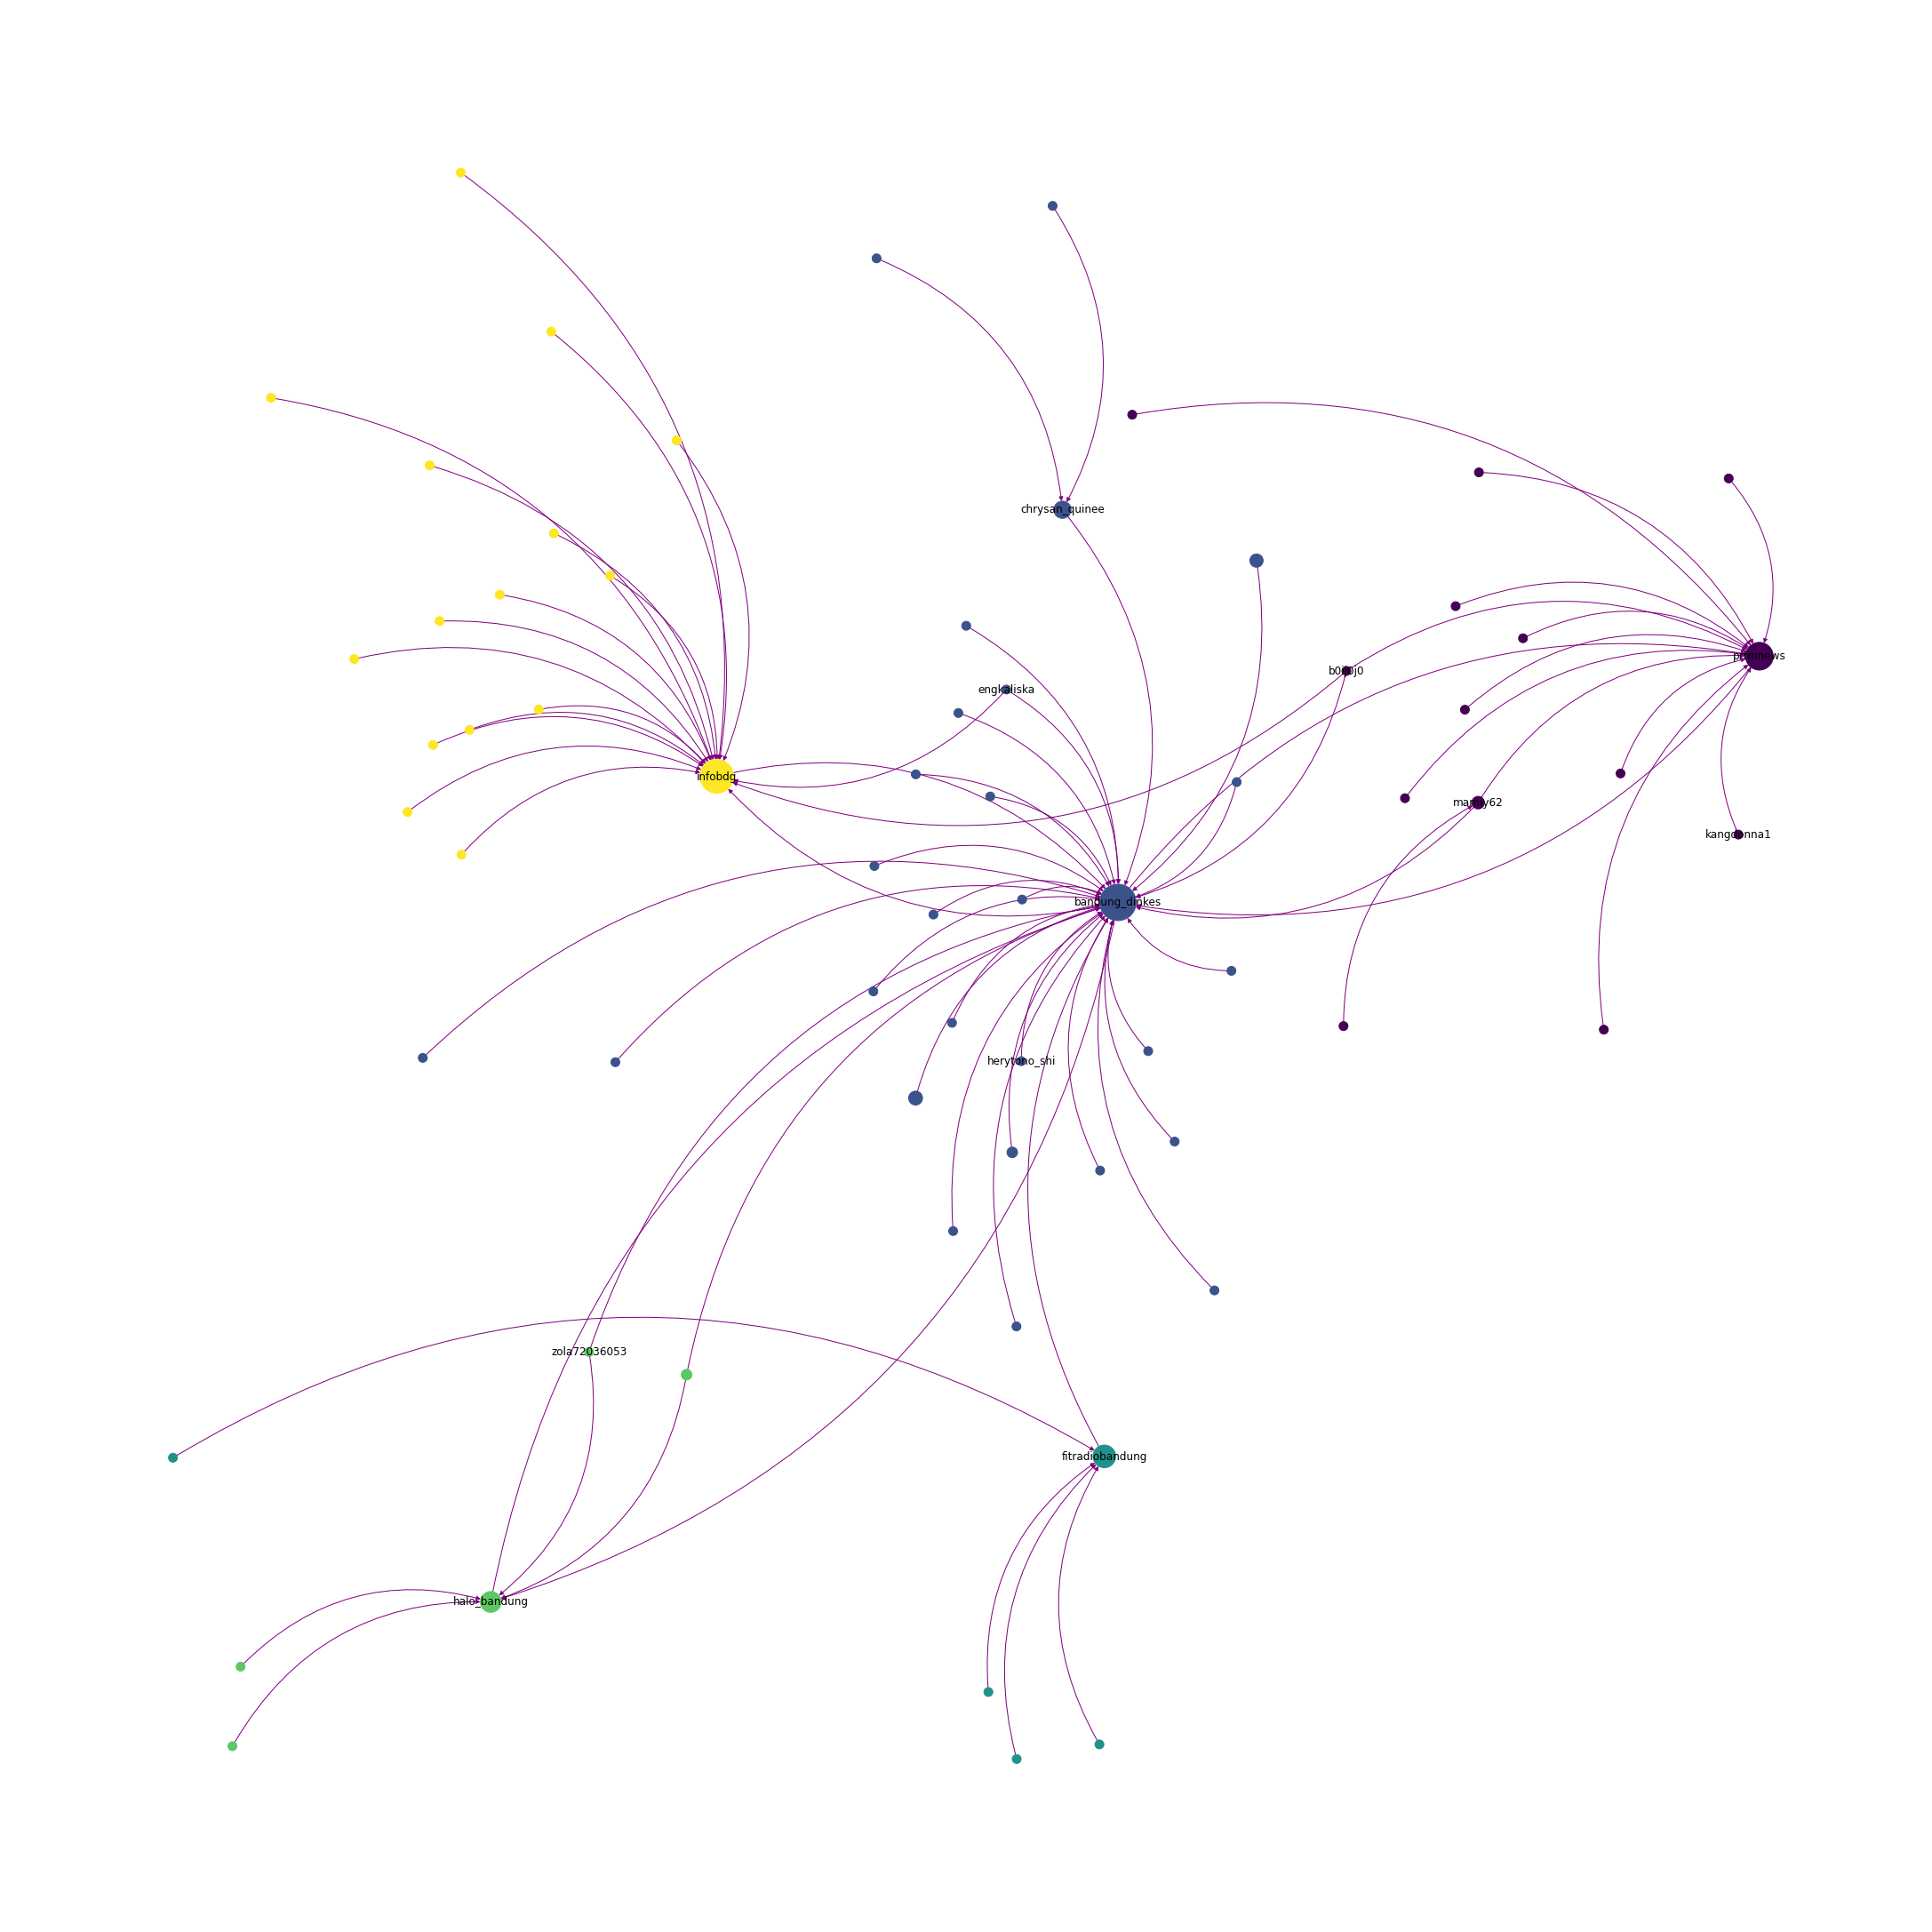

In [117]:
from networkx.algorithms import node_classification
G2_undirected = G2.to_undirected()

mainActor = ['prfmnews', 'bandung_dinkes', 'fitradiobandung', 'halo_bandung', 'infobdg']
for idx, i in enumerate(mainActor):
    G2_undirected.nodes[i]['label'] = idx / 10
nodeColor = node_classification.harmonic_function(G2_undirected)

plt.figure(figsize=(30,30))
# pos = forceatlas2_layout(G2)
pos = nx.spring_layout(G2)
nx.draw(G2, with_labels=False, edge_color='purple', node_size=nodeSize, node_color=nodeColor ,node_shape = 'o' , pos=pos, connectionstyle='arc3, rad = -0.3')
nx.draw_networkx_labels(G2, pos ,labels=af_labels)
plt.show()